In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
df = pd.read_csv('data/csv/loradata-aggregate.csv', 
                 dtype={
                     'gatewayID': object, 
                     'spreadingFactor': float
                 })

In [18]:
key_columns_01 = ['timeIngested', 'publishedAt', 'time', 
                  'rssi', 'spreadingFactor', 'bandwidth', 'frequency', 'codeRate', 'channel', 'loRaSNR']

df = df.dropna(subset=key_columns_01, how='any')

# Identify the key columns based on which you want to deduplicate the rows
# To remove the messages that were sent twice by gateways (or received twice by network servers) (network Bugs)
key_columns_02 = ['devEUI', 'spreadingFactor', 'bandwidth', 'frequency', 'codeRate',
                  'gatewayID', 'rssi', 'time', 'channel', 'loRaSNR']

# Drop duplicate rows based on the specified key columns
df_deduplicated = df.drop_duplicates(subset=key_columns_02, keep='first')

# To remove the messages that have two gateway IDs that are the same (network Bugs)
key_columns_03 = ['rawMeasurementId', 'timeIngested', 'publishedAt', 'gatewayID']
df_deduplicated = df_deduplicated.drop_duplicates(subset=key_columns_03, keep=False)

# Data collected by gateways On Campus
df_deduplicated = df_deduplicated[
    (df_deduplicated['gatewayID'] == '0000024B080301BF')
    | (df_deduplicated['gatewayID'] == 'A840411DA56C4150')
    | (df_deduplicated['gatewayID'] == 'A840411EAE004150')
    | (df_deduplicated['gatewayID'] == 'A840411EE8904150')
    | (df_deduplicated['gatewayID'] == 'A840411EADFC4150')
]

# RA is the Ravelijn buidling
df_RA = df_deduplicated[
    ((df_deduplicated['gatewayID'] == 'A840411DA56C4150') | (df_deduplicated['gatewayID'] == 'A840411EAE004150'))
    & ((df_deduplicated['spreadingFactor'] == 7) | (df_deduplicated['spreadingFactor'] == 12))
]

key_columns_04 = ['rawMeasurementId', 'timeIngested', 'publishedAt', 'devEUI']
df_RA_group = df_RA.groupby(key_columns_04).size().reset_index(name='Count')

df_RA_both = df_RA_group[df_RA_group['Count'] > 1]

res = df_RA[
    df_RA['rawMeasurementId'].isin(df_RA_both['rawMeasurementId']) 
    & df_RA['timeIngested'].isin(df_RA_both['timeIngested']) 
    & df_RA['publishedAt'].isin(df_RA_both['publishedAt']) 
    & df_RA['devEUI'].isin(df_RA_both['devEUI'])
]

In [19]:
group_counts = res.groupby(['devEUI', 'spreadingFactor', 'gatewayID']).size()
# Sort the group counts in descending order
group_counts_sorted = group_counts.reset_index(name='Count').sort_values(by='Count', ascending=False)
#group_counts_sorted.to_csv('RA-gateways-group_counts-order-by-count.csv', header = ['devEUI', 'spreadingFactor', 'gatewayID', 'Count'], index=False)

In [20]:
df_devEUI_roomname = pd.read_csv('data/loc/devEUI_roomname.csv')

def to_str(value):
    return str(value)

df_devEUI_roomname['location_id'] = df_devEUI_roomname['location_id'].apply(lambda x: to_str(x))

def roomname(value):
    return value.split('-')[0]

df_devEUI_roomname['roomname'] = df_devEUI_roomname['roomname'].apply(lambda x: roomname(x))

In [21]:
# Filter the data for the first boxplot
# There are two gateways in RA, A840411DA56C4150 and A840411EAE004150
df_RA_SF7_A840411DA56C4150 = res[
    (res['spreadingFactor'] == 7) 
    & (res['gatewayID'] == 'A840411DA56C4150')
]

# Filter the data for the second boxplot
df_RA_SF7_A840411EAE004150 = res[
    (res['spreadingFactor'] == 7) 
    & (res['gatewayID'] == 'A840411EAE004150')
]

# Filter the data for the first boxplot
df_RA_SF12_A840411DA56C4150 = res[
    (res['spreadingFactor'] == 12) 
    & (res['gatewayID'] == 'A840411DA56C4150') 
    & (res['rssi'] < 0) 
    & (res['rssi'] > -146)
]

# Filter the data for the second boxplot
df_RA_SF12_A840411EAE004150 = res[
    (res['spreadingFactor'] == 12) 
    & (res['gatewayID'] == 'A840411EAE004150') 
    &(res['rssi'] < 0) 
    & (res['rssi'] > -146)]

# Filter 'devEUI' column based on common values
df_RA_SF7_A840411DA56C4150 = df_RA_SF7_A840411DA56C4150[df_RA_SF7_A840411DA56C4150['devEUI'].isin(df_RA_SF7_A840411EAE004150['devEUI'])]
df_RA_SF7_A840411EAE004150 = df_RA_SF7_A840411EAE004150[df_RA_SF7_A840411EAE004150['devEUI'].isin(df_RA_SF7_A840411DA56C4150['devEUI'])]
                                                         
df_RA_SF12_A840411DA56C4150 = df_RA_SF12_A840411DA56C4150[df_RA_SF12_A840411DA56C4150['devEUI'].isin(df_RA_SF12_A840411EAE004150['devEUI'])]
df_RA_SF12_A840411EAE004150 = df_RA_SF12_A840411EAE004150[df_RA_SF12_A840411EAE004150['devEUI'].isin(df_RA_SF12_A840411DA56C4150['devEUI'])]

df_RA_SF7_A840411DA56C4150 = df_RA_SF7_A840411DA56C4150[df_RA_SF7_A840411DA56C4150['devEUI'].isin(df_RA_SF12_A840411DA56C4150['devEUI'])]
df_RA_SF7_A840411EAE004150 = df_RA_SF7_A840411EAE004150[df_RA_SF7_A840411EAE004150['devEUI'].isin(df_RA_SF12_A840411DA56C4150['devEUI'])]
                                                         
df_RA_SF12_A840411DA56C4150 = df_RA_SF12_A840411DA56C4150[df_RA_SF12_A840411DA56C4150['devEUI'].isin(df_RA_SF7_A840411DA56C4150['devEUI'])]
df_RA_SF12_A840411EAE004150 = df_RA_SF12_A840411EAE004150[df_RA_SF12_A840411EAE004150['devEUI'].isin(df_RA_SF7_A840411DA56C4150['devEUI'])]

In [70]:
# show_all = False: only show 5 sensors on each floor of Ravelijn
def box_plot_gw(SF, 
                df_RA_A840411DA56C4150, 
                df_RA_A840411EAE004150, 
                ax, 
                set_xticklabels = False, 
                show_all = False):
    
    # Merge the DataFrames based on the 'devEUI' column
    df_RA_A840411DA56C4150 = pd.merge(df_devEUI_roomname, df_RA_A840411DA56C4150, on='devEUI', how='inner')
    
    devEUI = str(df_RA_A840411DA56C4150['devEUI'])
    anon = devEUI[0] + '*' + devEUI[-1]
    # Create a new column by combining 'roomname' and 'id'
    df_RA_A840411DA56C4150['devEUI'] = df_RA_A840411DA56C4150['roomname'] \
                                    + '-' \
                                    + df_RA_A840411DA56C4150['location_id'] \
                                    + '-' \
                                    + anon

    # Merge the DataFrames based on the 'devEUI' column
    df_RA_A840411EAE004150 = pd.merge(df_devEUI_roomname, 
                                      df_RA_A840411EAE004150, 
                                      on='devEUI', 
                                      how='inner')
    
    devEUI = str(df_RA_A840411EAE004150['devEUI'])
    anon = devEUI[0] + '*' + devEUI[-1]
    # Create a new column by combining 'roomname' and 'devEUI'
    df_RA_A840411EAE004150['devEUI'] = df_RA_A840411EAE004150['roomname'] \
                                    + '-' \
                                    + df_RA_A840411EAE004150['location_id'] \
                                    + '-' \
                                    + anon

    new_df_RA_A840411DA56C4150 = df_RA_A840411DA56C4150[df_RA_A840411DA56C4150['devEUI'].isin(df_RA_A840411EAE004150['devEUI'].unique())]
    new_df_RA_A840411EAE004150 = df_RA_A840411EAE004150[df_RA_A840411EAE004150['devEUI'].isin(df_RA_A840411DA56C4150['devEUI'].unique())]
    
    new_df_RA_A840411DA56C4150 = new_df_RA_A840411DA56C4150.sort_values('devEUI', ascending=False)
    new_df_RA_A840411EAE004150 = new_df_RA_A840411EAE004150.sort_values('devEUI', ascending=False)
    
    # Define the desired order of 'devEUI' values
    devEUI_ordered = new_df_RA_A840411EAE004150['devEUI'].unique()
    
    if show_all:
        # Create a figure and axes
        num_devEUIs = len(devEUI_ordered)
        #fig, ax = plt.subplots(figsize=(10, 4))

        # Generate positions for the boxplots
        positions = np.arange(1, num_devEUIs * 2 + 1, 2)
        
        # Reorder the 'devEUI' column based on the desired order
        new_df_RA_A840411DA56C4150['devEUI'] = pd.Categorical(new_df_RA_A840411DA56C4150['devEUI'], 
                                                              categories=devEUI_ordered, 
                                                              ordered=True)
        
        new_df_RA_A840411EAE004150['devEUI'] = pd.Categorical(new_df_RA_A840411EAE004150['devEUI'], 
                                                              categories=devEUI_ordered, 
                                                              ordered=True)
    else:
        # RA5 - the fifth floor of RA
        f5 = [item for item in devEUI_ordered if 'RA5' in item]
        f5 = f5[:5]
        # RA4 - the forth floor of RA
        f4 = [item for item in devEUI_ordered if 'RA4' in item]
        f4 = f4[:5]
        f3 = [item for item in devEUI_ordered if 'RA3' in item]
        f3 = f3[:5]
        f2 = [item for item in devEUI_ordered if 'RA2' in item]
        f2 = f2[:5]
        f1 = [item for item in devEUI_ordered if 'RA1' in item]
        f1 = f1[:5]

        euis = f5 + f4 + f3 + f2 + f1

        # Create a figure and axes
        num_devEUIs = len(euis)
        #fig, ax = plt.subplots(figsize=(10, 4))

        # Generate positions for the boxplots
        positions = np.arange(1, num_devEUIs * 2 + 1, 2)

        new_df_RA_A840411DA56C4150 = new_df_RA_A840411DA56C4150[new_df_RA_A840411DA56C4150['devEUI'].isin(euis)]
        new_df_RA_A840411EAE004150 = new_df_RA_A840411EAE004150[new_df_RA_A840411EAE004150['devEUI'].isin(euis)]

        # Reorder the 'devEUI' column based on the desired order
        new_df_RA_A840411DA56C4150['devEUI'] = pd.Categorical(new_df_RA_A840411DA56C4150['devEUI'], 
                                                              categories=euis, 
                                                              ordered=True)
        new_df_RA_A840411EAE004150['devEUI'] = pd.Categorical(new_df_RA_A840411EAE004150['devEUI'], 
                                                              categories=euis, 
                                                              ordered=True)
    
    # Boxplot for df_RA_A840411DA56C4150 with orange color
    box_plot1 = new_df_RA_A840411DA56C4150.boxplot(column=['rssi'], 
                                                   by='devEUI', 
                                                   ax=ax, 
                                                   color='orange', 
                                                   positions=positions)
    
    # Boxplot for df_RA_A840411EAE004150 with green color
    box_plot2 = new_df_RA_A840411EAE004150.boxplot(column=['rssi'], 
                                                   by='devEUI', 
                                                   ax=ax, 
                                                   color='green', 
                                                   positions=positions + 1)

    # Set labels and title
    ax.set_xlabel('')
    #ax.set_ylabel('RSSI (Using SF' + str(SF) + ')')
    ax.set_ylabel('RSSI')
    #ax.set_title('Boxplots of RSSI by devEUI')

    # Adjust x-axis ticks and labels
    ax.set_xticks(positions + 0.5)
    if show_all:
        if set_xticklabels:
            ax.set_xticklabels(devEUI_ordered)
    else:
        if set_xticklabels:
            ax.set_xticklabels(euis)
            for label in ax.get_xticklabels()[(len(f5) + len(f4)):]:
                label.set_weight('bold')
    
    if not set_xticklabels:
        orange_patch = mpatches.Patch(color='orange', label='Gateway - UTwente Ravelijn rooftop')
        green_patch = mpatches.Patch(color='green', label='Gateway - UT Ravelijn indoor')
        ax.legend(handles=[orange_patch, green_patch], loc='upper left')

    # Remove the title
    box_plot1.set_title('')
    box_plot2.set_title('')

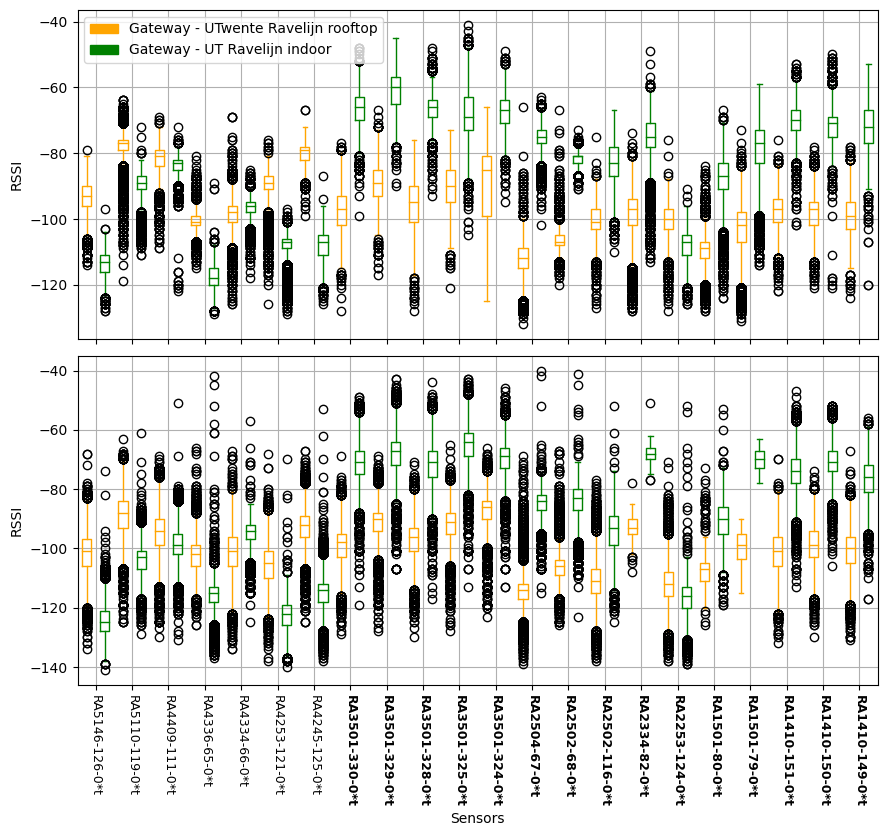

In [71]:
show_all = False
# Create a figure with two subplots arranged vertically
if show_all:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 9))
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))
    
box_plot_gw(7, 
            df_RA_SF7_A840411DA56C4150, 
            df_RA_SF7_A840411EAE004150, 
            ax1, 
            set_xticklabels = False, 
            show_all = show_all)

box_plot_gw(12, 
            df_RA_SF12_A840411DA56C4150, 
            df_RA_SF12_A840411EAE004150, 
            ax2, 
            set_xticklabels = True, 
            show_all = show_all)

plt.xticks(rotation=270, fontsize=9)
    # Optional: Set title and labels for the plot
    #plt.title('Boxplot of Sensors-RSSI-SF7')
plt.xlabel('Sensors')
#plt.ylabel('RSSI')

plt.subplots_adjust(hspace=0.05)

fig.suptitle('')
plt.savefig('plots/RA-SF7-SF12-RSSI.pdf', bbox_inches='tight')
# Display the merged plots
plt.show()

In [72]:
def box_plot_SF(gw, 
                df_RA_SF7_gateway, 
                df_RA_SF12_gateway, 
                ax, 
                set_xticklabels = False, 
                show_all = False):
    
    # Merge the DataFrames based on the 'devEUI' column
    df_RA_SF7_gateway = pd.merge(df_devEUI_roomname, 
                                 df_RA_SF7_gateway, 
                                 on='devEUI', 
                                 how='inner')
    
    devEUI = str(df_RA_SF7_gateway['devEUI'])
    anon = devEUI[0] + '*' + devEUI[-1]
    # Create a new column by combining 'roomname' and 'id'
    df_RA_SF7_gateway['devEUI'] = df_RA_SF7_gateway['roomname'] \
                                + '-' \
                                + df_RA_SF7_gateway['location_id'] \
                                + '-' \
                                + anon

    # Merge the DataFrames based on the 'devEUI' column
    df_RA_SF12_gateway = pd.merge(df_devEUI_roomname, 
                                  df_RA_SF12_gateway, 
                                  on='devEUI', 
                                  how='inner')
    
    devEUI = str(df_RA_SF12_gateway['devEUI'])
    anon = devEUI[0] + '*' + devEUI[-1]
    # Create a new column by combining 'roomname' and 'devEUI'
    df_RA_SF12_gateway['devEUI'] = df_RA_SF12_gateway['roomname'] \
                                + '-' \
                                + df_RA_SF12_gateway['location_id'] \
                                + '-' \
                                + anon

    new_df_RA_SF7_gateway = df_RA_SF7_gateway[df_RA_SF7_gateway['devEUI'].isin(df_RA_SF12_gateway['devEUI'].unique())]
    new_df_RA_SF12_gateway = df_RA_SF12_gateway[df_RA_SF12_gateway['devEUI'].isin(df_RA_SF7_gateway['devEUI'].unique())]
    
    new_df_RA_SF7_gateway = new_df_RA_SF7_gateway.sort_values('devEUI', ascending=False)
    new_df_RA_SF12_gateway = new_df_RA_SF12_gateway.sort_values('devEUI', ascending=False)
    
    # Define the desired order of 'devEUI' values
    devEUI_ordered = new_df_RA_SF12_gateway['devEUI'].unique()
    
    if show_all:
        # Create a figure and axes
        num_devEUIs = len(devEUI_ordered)

        # Generate positions for the boxplots
        positions = np.arange(1, num_devEUIs * 2 + 1, 2)

        # Reorder the 'devEUI' column based on the desired order
        new_df_RA_SF7_gateway['devEUI'] = pd.Categorical(new_df_RA_SF7_gateway['devEUI'], 
                                                         categories=devEUI_ordered, 
                                                         ordered=True)
        
        new_df_RA_SF12_gateway['devEUI'] = pd.Categorical(new_df_RA_SF12_gateway['devEUI'], 
                                                          categories=devEUI_ordered, 
                                                          ordered=True)
    else: 
        f5 = [item for item in devEUI_ordered if 'RA5' in item]
        f5 = f5[:5]
        f4 = [item for item in devEUI_ordered if 'RA4' in item]
        f4 = f4[:5]
        f3 = [item for item in devEUI_ordered if 'RA3' in item]
        f3 = f3[:5]
        f2 = [item for item in devEUI_ordered if 'RA2' in item]
        f2 = f2[:5]
        f1 = [item for item in devEUI_ordered if 'RA1' in item]
        f1 = f1[:5]

        euis = f5 + f4 + f3 + f2 + f1

        # Create a figure and axes
        num_devEUIs = len(euis)

        # Generate positions for the boxplots
        positions = np.arange(1, num_devEUIs * 2 + 1, 2)

        new_df_RA_SF7_gateway = new_df_RA_SF7_gateway[new_df_RA_SF7_gateway['devEUI'].isin(euis)]
        new_df_RA_SF12_gateway = new_df_RA_SF12_gateway[new_df_RA_SF12_gateway['devEUI'].isin(euis)]

        # Reorder the 'devEUI' column based on the desired order
        new_df_RA_SF7_gateway['devEUI'] = pd.Categorical(new_df_RA_SF7_gateway['devEUI'], 
                                                         categories=euis, 
                                                         ordered=True)
        
        new_df_RA_SF12_gateway['devEUI'] = pd.Categorical(new_df_RA_SF12_gateway['devEUI'], 
                                                          categories=euis, 
                                                          ordered=True)
    
    # Boxplot for df_RA_SF7_gateway with orange color
    box_plot1 = new_df_RA_SF7_gateway.boxplot(column=['rssi'], 
                                              by='devEUI', 
                                              ax=ax, 
                                              color='orange', 
                                              positions=positions)
    
    # Boxplot for df_RA_SF12_gateway with green color
    box_plot2 = new_df_RA_SF12_gateway.boxplot(column=['rssi'], 
                                               by='devEUI', 
                                               ax=ax, 
                                               color='green', 
                                               positions=positions + 1)

    # Set labels and title
    ax.set_xlabel('')
    #ax.set_ylabel('RSSI (Using SF' + str(SF) + ')')
    ax.set_ylabel('RSSI')
    #ax.set_title('Boxplots of RSSI by devEUI')

    # Adjust x-axis ticks and labels
    ax.set_xticks(positions + 0.5)
    if show_all:
        if set_xticklabels:
            ax.set_xticklabels(devEUI_ordered)
    else:    
        if set_xticklabels:
            ax.set_xticklabels(euis)
    
    if not set_xticklabels:
        orange_patch = mpatches.Patch(color='orange', label='SF7')
        green_patch = mpatches.Patch(color='green', label='SF12')
        ax.legend(handles=[orange_patch, green_patch], loc='upper left')

    # Remove the title
    box_plot1.set_title('')
    box_plot2.set_title('')

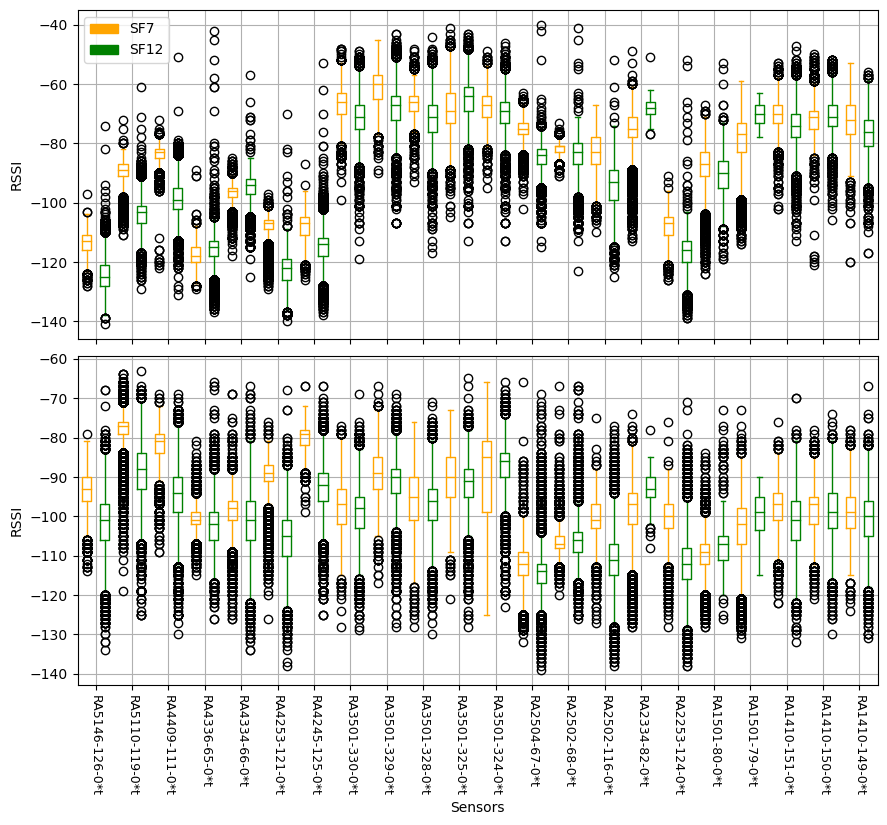

In [73]:
show_all = False
# Create a figure with two subplots arranged vertically
if show_all:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 9))
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

box_plot_SF('A840411EAE004150', 
            df_RA_SF7_A840411EAE004150, 
            df_RA_SF12_A840411EAE004150, 
            ax1, 
            set_xticklabels = False, 
            show_all = show_all)

box_plot_SF('A840411DA56C4150', 
            df_RA_SF7_A840411DA56C4150, 
            df_RA_SF12_A840411DA56C4150, 
            ax2, 
            set_xticklabels = True, 
            show_all = show_all)

plt.xticks(rotation=270, fontsize=9)
plt.xlabel('Sensors')

plt.subplots_adjust(hspace=0.05)

fig.suptitle('')
plt.savefig('plots/RA-SF7-SF12-gateway-RSSI.pdf', bbox_inches='tight')
# Display the merged plots
plt.show()

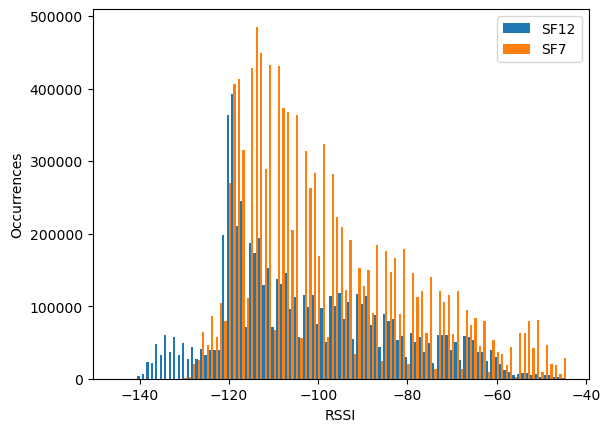

In [74]:
def plot_RSSI(df, category):
    category = 'RSSI'
    file_name = category
    complete_rssi = range(-145, -44)
    
    df7 = df[
        (df['spreadingFactor'] == 7) 
        & (df['rssi'] <= -45) 
        & (df['rssi'] >= -145)
    ]
    
    msg_num7 = df7.groupby(['rssi']).size().reset_index(name='Count-SF7')
    msg_num7 = msg_num7.set_index('rssi').reindex(complete_rssi, fill_value=0).reset_index()
    msg_num7.to_csv(file_name + '-' + category + '-SF7.csv', header=['rssi', 'Count'], index=False)

    df12 = df[
        (df['spreadingFactor'] == 12) 
        & (df['rssi'] <= -45) 
        & (df['rssi'] >= -145)
    ]
    
    msg_num12 = df12.groupby(['rssi']).size().reset_index(name='Count-SF12')
    msg_num12 = msg_num12.set_index('rssi').reindex(complete_rssi, fill_value=0).reset_index()
    msg_num12.to_csv(file_name + '-' + category + '-SF12.csv', 
                     header=['rssi', 'Count'], 
                     index=False)
    
    plt.bar([a-0.25 for a in msg_num12['rssi']], 
            msg_num12['Count-SF12'], 
            label='SF12', 
            color='#1f77b4', 
            width=0.5)
    
    plt.bar([a+0.25 for a in msg_num7['rssi']], 
            msg_num7['Count-SF7'],
            label='SF7', 
            color='#ff7f0e', 
            width=0.5)
    
    plt.xlabel('RSSI')
    plt.ylabel('Occurrences')
    plt.legend()
    plt.savefig('plots/SF7-SF12.png', bbox_inches='tight')
    plt.show()
    plt.close()

plot_RSSI(df_deduplicated, 'all')

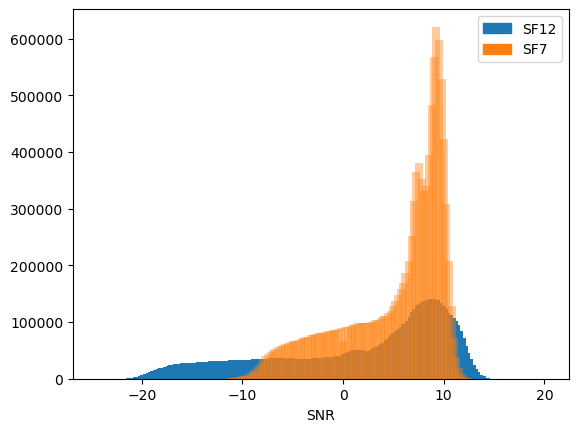

In [75]:
dd = df_deduplicated[
    (df_deduplicated['spreadingFactor'] == 12) 
    & (df_deduplicated['rssi'] < 0) 
    & (df_deduplicated['loRaSNR'] < 21)
    & (df_deduplicated['loRaSNR'] > -26)
]

msg_num12 = dd.groupby(['loRaSNR']).size().reset_index(name='Count-SF12')
plt.bar(msg_num12['loRaSNR'], msg_num12['Count-SF12'], label='SF12', color='#1f77b4')

df7 = df_deduplicated[
    (df_deduplicated['spreadingFactor'] == 7) 
    & (df_deduplicated['rssi'] < 0)
    & (df_deduplicated['loRaSNR'] < 21)
    & (df_deduplicated['loRaSNR'] > -26)
]

msg_num7 = df7.groupby(['loRaSNR']).size().reset_index(name='Count-SF7')
plt.bar(msg_num7['loRaSNR'], msg_num7['Count-SF7'], label='SF7', color= '#ff7f0e', alpha=0.4)

plt.xlabel('SNR')

orange_patch = mpatches.Patch(color='#1f77b4', label='SF12')
green_patch = mpatches.Patch(color= '#ff7f0e', label='SF7')
plt.legend(handles=[orange_patch, green_patch], loc='upper right')

plt.savefig('plots/SNR-SF7-SF12.png', bbox_inches='tight')

plt.show()